In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from matplotlib import style
from matplotlib.dates import DateFormatter, AutoDateLocator

from scipy import stats

## Definice funkci

In [3]:
#region Tvorba vlastnich atributu

# vraci dvojici (dict/L3, dict/L4) ktery priradi kazde komunikaci v df unikatni identifikator
# d_l3: klic je tuple (srcIP, dstIP) a hodnota je nove vygenerovane id komunikace
# d_l4: klic je tuple (srcIP, srcPort, dstIP, dstPort) a hodnota je nove vygenerovane id komunikace
def find_communication_pairs(df: pd.DataFrame) -> tuple:
    d_l3 = dict()
    d_l4 = dict()
    i, j = 1, 1
    for (srcIP, srcPort, dstIP, dstPort) in zip(df.srcIP, df.srcPort, df.dstIP, df.dstPort):
        # L3
        if (srcIP, dstIP) not in d_l3:
            d_l3[(srcIP, dstIP)] = i
            i = i + 1
        
        # L4
        if (srcIP, srcPort, dstIP, dstPort) not in d_l4:
            d_l4[(srcIP, srcPort, dstIP, dstPort)] = j
            j = j + 1

    return d_l3, d_l4

# vraci list ktery priradi kazdemu zaznamu v df relativni cislo oznacujici den
# nesmi byt mezi casy mezera vetsi nez 24h (jinak se packety priradi nespravne do jednoho dne)
# [0..0, 1..1, 2..2, 3..3, ...]
def find_relative_days(df: pd.DataFrame) -> list:
    # krajni pripady
    if len(df.index) == 0:
        return []
    if len(df.index) == 1:
        return [0]

    # jadro funkce
    l = [0]
    counter = 0
    for i in range(1, len(df.index)):
        if df['TimeStamp'][i].time() < df['TimeStamp'][i-1].time():
            counter += 1
        l.append(counter)
    return l

#endregion

#region Filtry

# Vraci df vyfiltrovany podle absolutniho casu (vcetne hranicnich hodnot)
def filter_by_time_abs(df: pd.DataFrame, start: datetime, end: datetime) -> pd.DataFrame:
    return df[(df['TimeStamp'] >= start) & (df['TimeStamp'] <= end)]

# Vraci df vyfiltrovany podle relativniho casu (vcetne hranicnich hodnot)
def filter_by_time_rel(df: pd.DataFrame, end: float) -> pd.DataFrame:
    return filter_by_time_rel(df, 0.0, end)

def filter_by_time_rel(df: pd.DataFrame, start: float, end: float) -> pd.DataFrame:
    return df[(df['Relative Time'] >= start) & (df['Relative Time'] <= end)]

#endregion

## Nacteni a predzpracovani dataframu

In [34]:
# Nacteni df
file = "data/mega104-14-12-18-ioa.csv"
# file = "data/mega104-17-12-18-ioa.csv"
df = pd.read_csv(file, sep=";", dtype={'asduType':'category', 'numix':'category', 'cot':'category', 'uType':'category', 'oa':'category'})

# df = df[df['uType'].str.contains("nan") == False]

df.head()

print(df.head().to_latex())

# # prida sloupce 'commL3Id' a 'commL4Id' do dataframu s id komunikaci
# cp_l3, cp_l4 = find_communication_pairs(df)
# df['commL3Id'] = df.apply(lambda row: cp_l3[(row.srcIP, row.dstIP)], axis=1).astype("category")
# df['commL4Id'] = df.apply(lambda row: cp_l4[(row.srcIP, row.srcPort, row.dstIP, row.dstPort)], axis=1).astype("category")

# # prevede prvni sloupec do datetime typu
# df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format="%H:%M:%S.%f")

# # prida relativni cislo dne (protoze timestamp neobsahuje informaci o datu)
# df['relativeDay'] = find_relative_days(df)

# # pricteni relativniho poctu dnu
# # datumy nebudou davat smysl ale odlisi se jednotlive dny od sebe
# df['TimeStamp'] = df.apply(lambda row: row.TimeStamp + timedelta(days=row.relativeDay), axis=1)


\begin{tabular}{llrllrrrrllllllrl}
\toprule
{} &    TimeStamp &  Relative Time &           srcIP &           dstIP &  srcPort &  dstPort &  ipLen &  len &         fmt & uType & asduType & numix & cot & oa &     addr &    ioa \\
\midrule
0 &  17:15:49.91 &       0.000000 &  192.168.11.111 &  192.168.11.248 &    56693 &     2404 &     59 &   17 &  0x00000000 &   NaN &      122 &     1 &  13 &  0 &  65535.0 &  65537 \\
1 &  17:15:49.94 &       0.029377 &  192.168.11.248 &  192.168.11.111 &     2404 &    56693 &     61 &   19 &  0x00000000 &   NaN &      120 &     1 &  13 &  0 &  65535.0 &  65537 \\
2 &  17:15:49.94 &       0.029617 &  192.168.11.111 &  192.168.11.248 &    56693 &     2404 &     59 &   17 &  0x00000000 &   NaN &      122 &     1 &  13 &  0 &  65535.0 &  65537 \\
3 &  17:15:49.94 &       0.031586 &  192.168.11.248 &  192.168.11.111 &     2404 &    56693 &     62 &   20 &  0x00000000 &   NaN &      121 &     1 &  13 &  0 &  65535.0 &  65537 \\
4 &  17:15:49.97 &       0.0624

## Filtrace

In [5]:
# ukazka filtrace dle casoveho razitka (potreba vyresit chybejici datum)
if False:
    start = datetime.strptime("17:15:49.97", '%H:%M:%S.%f')
    end = datetime.strptime("17:15:50.17", '%H:%M:%S.%f')
    filtered_df = filter_by_time_abs(df, start, end)

# ukazka filtrace dle casoveho razitka (potreba vyresit chybejici datum)
if False:
    filtered_df = filter_by_time_rel(df, 0, 60)


# df = filtered_df

## Pocet paketu v jednotlivych komunikacich internetové vrstvy (L3)

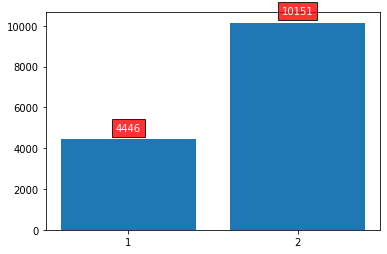

1: 192.168.11.111 -> 192.168.11.248
2: 192.168.11.248 -> 192.168.11.111


In [6]:
# comm_ids = list(f"{x}\n{y}" for x,y in communication_pairs.keys())
comm_ids = list(str(x) for x in cp_l3.values())
comm_count = list(np.count_nonzero(df.commL3Id == x) for x in cp_l3.values())
# labels = communication_pairs.values()
plt.bar(x = comm_ids, height = comm_count)

# pridani labelu s poctem nad sloupce
offset = max(comm_count) / 25
for i in range(len(comm_ids)):
        plt.text(i, comm_count[i] + offset, comm_count[i], ha = 'center', color='white', bbox = dict(facecolor = 'red', alpha =.8))

plt.show()

# vypise idcka komunikace
for k, v in cp_l3.items():
    print(f"{v}: {k[0]} -> {k[1]}")

## Pocet paketu v jednotlivych komunikacich transportní vrstvy (L4)

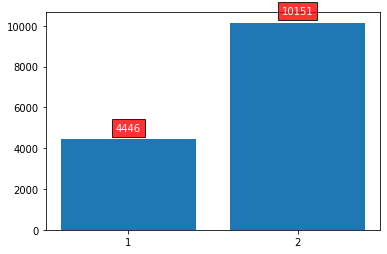

1: 192.168.11.111:56693 -> 192.168.11.248:2404
2: 192.168.11.248:2404 -> 192.168.11.111:56693


In [7]:
# comm_ids = list(f"{x}\n{y}" for x,y in communication_pairs.keys())
comm_ids = list(str(x) for x in cp_l4.values())
comm_count = list(np.count_nonzero(df.commL4Id == x) for x in cp_l4.values())
# labels = communication_pairs.values()
plt.bar(x = comm_ids, height = comm_count)

# pridani labelu s poctem nad sloupce
offset = max(comm_count) / 25
for i in range(len(comm_ids)):
        plt.text(i, comm_count[i] + offset, comm_count[i], ha = 'center', color='white', bbox = dict(facecolor = 'red', alpha =.8))

plt.show()

# vypise idcka komunikace
for k, v in cp_l4.items():
    print(f"{v}: {k[0]}:{k[1]} -> {k[2]}:{k[3]}")

# pozn: tento kod je stejny jako o bunku vyse az na pouzity dict a for loop pro vypis

## Pocet paketu v jednotlivych casovych usecich

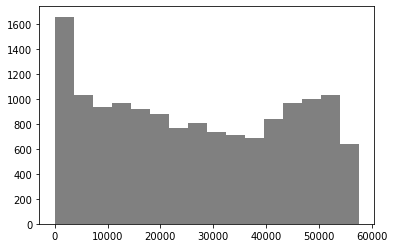

0 - 1: 1661
1 - 2: 1032
2 - 3: 940
3 - 4: 969
4 - 5: 922
5 - 6: 880
6 - 7: 765
7 - 8: 807
8 - 9: 733
9 - 10: 709
10 - 11: 692
11 - 12: 839
12 - 13: 972
13 - 14: 1002
14 - 15: 1032
15 - 16: 642


In [8]:
bin_size = 3600 # sirka slopce v sekundach
x = np.arange(0, df['Relative Time'].max() + bin_size, bin_size)
n, bins, _ = plt.hist(df['Relative Time'], x, facecolor='gray', align='mid')
plt.show()

# adhoc reseni pro zobrazeni poctu paketu v jednotlivich hodinach (relativnich!)
for i in range(len(n)):
    print(f"{int(bins[i]/3600)} - {int(bins[i+1]/3600)}: {int(n[i])}")

TimeStamp
1900-01-01 17:00:00    858
1900-01-01 17:30:00    524
1900-01-01 18:00:00    526
1900-01-01 18:30:00    521
1900-01-01 19:00:00    500
1900-01-01 19:30:00    465
1900-01-01 20:00:00    482
1900-01-01 20:30:00    487
1900-01-01 21:00:00    466
1900-01-01 21:30:00    452
1900-01-01 22:00:00    453
1900-01-01 22:30:00    454
1900-01-01 23:00:00    405
1900-01-01 23:30:00    377
1900-01-02 00:00:00    392
1900-01-02 00:30:00    420
1900-01-02 01:00:00    369
1900-01-02 01:30:00    372
1900-01-02 02:00:00    348
1900-01-02 02:30:00    355
1900-01-02 03:00:00    358
1900-01-02 03:30:00    339
1900-01-02 04:00:00    347
1900-01-02 04:30:00    437
1900-01-02 05:00:00    468
1900-01-02 05:30:00    470
1900-01-02 06:00:00    500
1900-01-02 06:30:00    506
1900-01-02 07:00:00    525
1900-01-02 07:30:00    512
1900-01-02 08:00:00    503
1900-01-02 08:30:00    406
Freq: 30T, dtype: int64

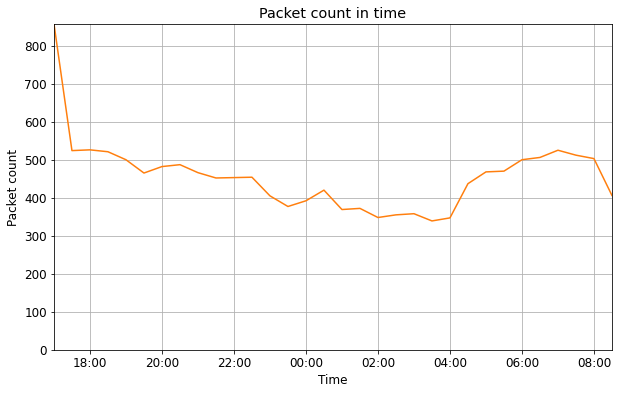

In [9]:
time_series = pd.Series(df.TimeStamp.index, index=df.TimeStamp)
ts = time_series.resample('30min').count()
# viz https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

x = ts.index
y = ts.values

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y, color='tab:orange')

ax.set_xlabel('Time')
ax.set_ylabel('Packet count')
ax.set_title('Packet count in time')
ax.grid(True)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

plt.xlim([min(x), max(x)])
plt.ylim([0, max(y)])

ts

# todo kategoricke atributy rozdelit do sloupcu  a udelat sumu pro kazdou kategorii

## Korelace mezi 'ipLen' a 'len'

Hodnota korelace: 0.925036597167055


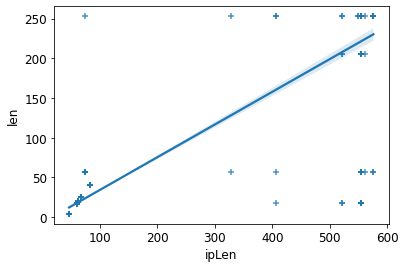

In [10]:
# vypocet korelace mezi 'ipLen' a 'len'
col1 = df['ipLen']
col2 = df['len']

correlation = col1.corr(col2)
print(f"Hodnota korelace: {correlation}")

# Jednoduchy graf pro zobrazeni korelace
sns.regplot(x=col1, y=col2, marker="+")
plt.show()

# vytahnout podezrele body
# matice + kategoricka analyza
# cetnosti hodnot (a kombinaci?)

In [11]:
# matice korelace mezi vsemi sloupci
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/home/ankimme/ibt/env/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/ankimme/ibt/env/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,Relative Time,srcPort,dstPort,ipLen,len,addr,relativeDay
Relative Time,1.000000,0.021397,-0.021397,-0.218150,-0.206991,nan,0.876849
srcPort,0.021397,1.000000,-1.000000,-0.217314,-0.364346,nan,0.036043
dstPort,-0.021397,-1.000000,1.000000,0.217314,0.364346,nan,-0.036043
ipLen,-0.218150,-0.217314,0.217314,1.000000,0.925037,nan,-0.156414
len,-0.206991,-0.364346,0.364346,0.925037,1.000000,nan,-0.155493
addr,nan,nan,nan,nan,nan,nan,nan
relativeDay,0.876849,0.036043,-0.036043,-0.156414,-0.155493,nan,1.000000


Pearson: 0.925
Spearman: 0.995
Pearson: 1.0
Spearman: 1.0
Pearson: 0.931
Spearman: 0.966


Text(0.5, 1.0, 'Druhy smer')

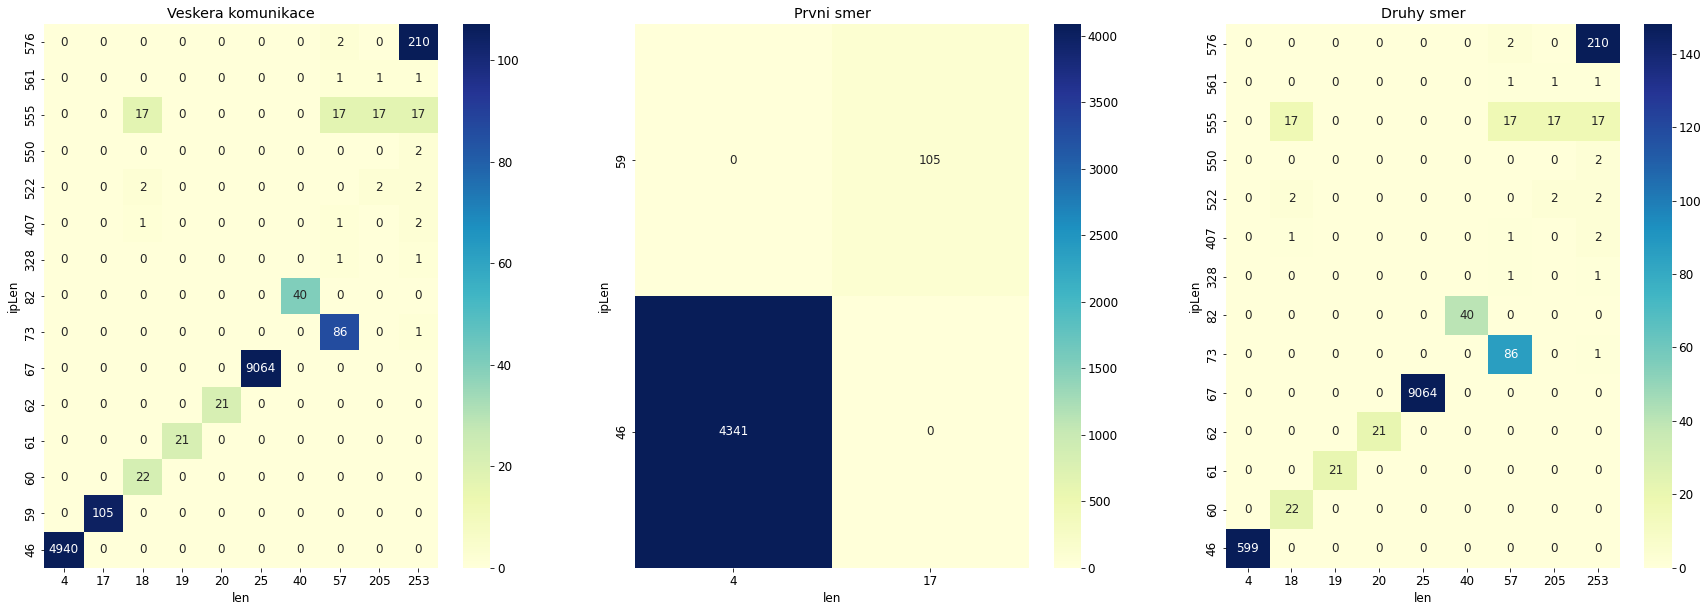

In [12]:

x = list(df.ipLen)
y = list(df.len)

x1 = list(df[df.commL4Id == 1].ipLen)
y1 = list(df[df.commL4Id == 1].len)

x2 = list(df[df.commL4Id == 2].ipLen)
y2 = list(df[df.commL4Id == 2].len)

# x: ipLen, y: len
def plot_heatmap(x, y, ax):
    # Pearson
    pearson_corr, _ = stats.pearsonr(x, y)
    print(f"Pearson: {pearson_corr:.3}")

    # Spearman
    spearman_corr, _ = stats.spearmanr(x, y)
    print(f"Spearman: {spearman_corr:.3}")

    d = dict()
    for a, b in zip(x, y):
        if (a, b) in d:
            d[(a, b)] += 1
        else:
            d[(a,b)] = 1

    # odstraneni duplicit
    x = list(set(x))
    y = list(set(y))

    x.sort(reverse=True)
    y.sort()

    result = []
    for i in x:
        row = []
        for j in y:
            if (i, j) in d:
                row.append(d[(i,j)])
            else:
                row.append(0)
        result.append(row)

    # fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(result, ax=ax, robust=True, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[str(i) for i in y], yticklabels=[str(i) for i in x])
    ax.set_xlabel("len")
    ax.set_ylabel("ipLen")


fig, axes = plt.subplots(1, 3, figsize=(30,10))

plot_heatmap(x, y, axes[0])
axes[0].set_title("Veskera komunikace")

plot_heatmap(x1, y1, axes[1])
axes[1].set_title(f"Prvni smer")

plot_heatmap(x2, y2, axes[2])
axes[2].set_title(f"Druhy smer")

# Poznamky

## Korelace

### Pearsonuv korelacni koeficient
- Snazi se napasovat linearni funkci `y=ax+b` na data.
- Cim lepe data kopiruji linearni funkci, tim vyssi index korelace je.

### Spearmanuv korelacni koeficint
- Kontorluje zda-li plati `y1 < y2` pro po sobe jdouci dvojice `x1 < x2`.
- Dava vysoke hodnoty pro funkci ktere jsou monotonni.

In [13]:
print(df.info())


print("----------")

print(df.uType.describe())
print(df.uType.value_counts())

print("----------")

print(df.asduType.describe())
print(df.asduType.value_counts())

print("----------")

print(df.numix.describe())
print(df.numix.value_counts())

print("----------")

print(df.cot.describe())
print(df.cot.value_counts())

print("----------")

print(df.oa.describe())
print(df.oa.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14597 entries, 0 to 14596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TimeStamp      14597 non-null  datetime64[ns]
 1   Relative Time  14597 non-null  float64       
 2   srcIP          14597 non-null  object        
 3   dstIP          14597 non-null  object        
 4   srcPort        14597 non-null  int64         
 5   dstPort        14597 non-null  int64         
 6   ipLen          14597 non-null  int64         
 7   len            14597 non-null  int64         
 8   fmt            14597 non-null  object        
 9   uType          1156 non-null   category      
 10  asduType       9657 non-null   category      
 11  numix          9657 non-null   category      
 12  cot            9657 non-null   category      
 13  oa             9657 non-null   category      
 14  addr           9657 non-null   float64       
 15  ioa            9657

In [19]:
df.ioa.value_counts()
# divne hodnoty

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,len,fmt,uType,asduType,numix,cot,oa,addr,ioa,commL3Id,commL4Id,relativeDay
0,1900-01-01 17:15:49.910,0.000000,192.168.11.111,192.168.11.248,56693,2404,59,17,0x00000000,NaN,122,1,13,0,65535.0,65537,1,1,0
1,1900-01-01 17:15:49.940,0.029377,192.168.11.248,192.168.11.111,2404,56693,61,19,0x00000000,NaN,120,1,13,0,65535.0,65537,2,2,0
2,1900-01-01 17:15:49.940,0.029617,192.168.11.111,192.168.11.248,56693,2404,59,17,0x00000000,NaN,122,1,13,0,65535.0,65537,1,1,0
3,1900-01-01 17:15:49.940,0.031586,192.168.11.248,192.168.11.111,2404,56693,62,20,0x00000000,NaN,121,1,13,0,65535.0,65537,2,2,0
4,1900-01-01 17:15:49.970,0.062488,192.168.11.111,192.168.11.248,56693,2404,59,17,0x00000000,NaN,122,1,13,0,65535.0,65537,1,1,0
